<a href="https://colab.research.google.com/github/Rhythm1821/Chest-Disease-Identifier/blob/main/Chest_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Import

### 1.1 Importing the data

In [1]:
!git clone https://github.com/adleberg/medical-ai

fatal: destination path 'medical-ai' already exists and is not an empty directory.


### 1.2 Import dependencies

In [2]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Welcome! Downloading some things... this will take a minute.")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

print("Great! You clicked on it correctly. Now let's get started.")

Welcome! Downloading some things... this will take a minute.
fatal: destination path 'medical-ai' already exists and is not an empty directory.
Great! You clicked on it correctly. Now let's get started.


In [3]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [4]:
df.shape

(1964, 9)

In [5]:
df.isna().sum()

filename      0
height        0
width         0
label         0
xmin        980
ymin        980
xmax        980
ymax        980
view          0
dtype: int64

In [6]:
df['label'].value_counts()

No Finding      980
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: label, dtype: int64

In [7]:
finding = "Cardiomegaly".capitalize()
positives = df.loc[df['label']==finding]
negatives = df.loc[df['label']=="No Finding"]
n = len(positives)
n

146

In [8]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2

TRAIN_N = int(n * TRAIN_RATIO)
TEST_N = int(n * TEST_RATIO)

print(TRAIN_N, TEST_N)

116 29


In [9]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:],negatives[TRAIN_N:n]])

In [10]:
train_labels.shape,test_labels.shape

((232, 9), (60, 9))

## 2 Preparing data

### 2.1 Preparing data directory

In [11]:
rootdir = '/content/medical-ai/images/'

os.makedirs(rootdir+finding+'/train/positive',  exist_ok=True)
os.makedirs(rootdir+finding+'/test/positive',  exist_ok=True)
os.makedirs(rootdir+finding+'/train/negative', exist_ok=True)
os.makedirs(rootdir+finding+'/test/negative', exist_ok=True)

In [12]:
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

In [13]:
# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

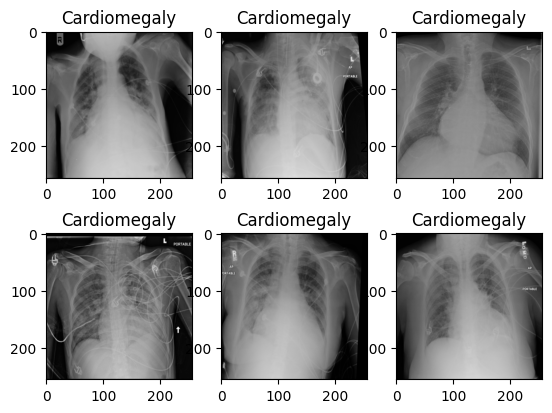

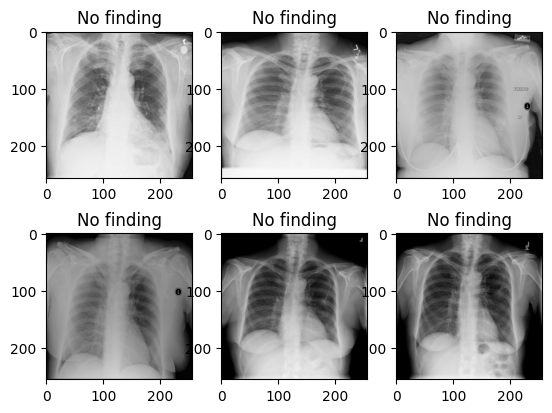

In [14]:
for idx,img in enumerate(positive_imgs[:6]):
  plt.subplot(2,3,idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx,img in enumerate(negative_imgs[:6]):
  plt.subplot(2,3,idx+1)
  plt.title("No finding")
  plt.imshow(negative_imgs[idx])
plt.show()

### 2.2 Building the neural network model using a pre-trained model - *InceptionV3*

In [15]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x) # Add a final sigmoid layer for classification

model = Model(pre_trained_model.input, x) # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

Done compiling the model!


In [16]:
# Define our example directories and files
base_dir = rootdir = "/content/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

### 2.3 Implementing data augmentation

In [17]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

# Note that the test data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


## 3 Train the model

### 3.1 Training the model

In [19]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=20,
                    validation_data=test_generator,
                    validation_steps=test_steps,
                    verbose=2)

Epoch 1/20
232/232 - 30s - loss: 11.0514 - acc: 0.5560 - val_loss: 8.3516 - val_acc: 0.5000 - 30s/epoch - 128ms/step
Epoch 2/20
232/232 - 11s - loss: 3.1104 - acc: 0.6336 - val_loss: 0.9618 - val_acc: 0.7000 - 11s/epoch - 48ms/step
Epoch 3/20
232/232 - 10s - loss: 0.7653 - acc: 0.6681 - val_loss: 0.6975 - val_acc: 0.6333 - 10s/epoch - 42ms/step
Epoch 4/20
232/232 - 9s - loss: 0.6190 - acc: 0.7155 - val_loss: 0.6054 - val_acc: 0.6333 - 9s/epoch - 40ms/step
Epoch 5/20
232/232 - 9s - loss: 0.5679 - acc: 0.7026 - val_loss: 0.4657 - val_acc: 0.7167 - 9s/epoch - 40ms/step
Epoch 6/20
232/232 - 10s - loss: 0.5343 - acc: 0.7371 - val_loss: 0.5576 - val_acc: 0.7000 - 10s/epoch - 41ms/step
Epoch 7/20
232/232 - 10s - loss: 0.5331 - acc: 0.7543 - val_loss: 0.6045 - val_acc: 0.7000 - 10s/epoch - 41ms/step
Epoch 8/20
232/232 - 9s - loss: 0.4954 - acc: 0.7888 - val_loss: 0.5384 - val_acc: 0.7333 - 9s/epoch - 40ms/step
Epoch 9/20
232/232 - 9s - loss: 0.5280 - acc: 0.7586 - val_loss: 0.3999 - val_acc: 0

### 3.2 Plot the model's loss and accuracy

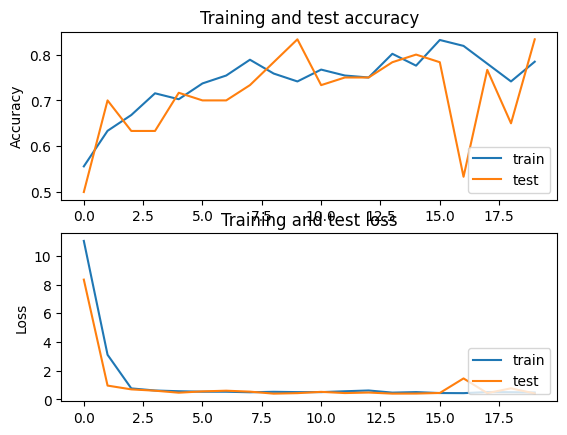

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs= range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs,acc,label='train')
plt.plot(epochs,val_acc,label='test')
plt.ylabel('Accuracy')
plt.title('Training and test accuracy')
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(epochs,loss,label='train')
plt.plot(epochs,val_loss,label='test')
plt.ylabel('Loss')
plt.title('Training and test loss')
plt.legend(loc='lower right')

## 4 Evaluating performance

### 4.1 Create a prediction function

In [21]:
def predict_image(filename):
    image = Image.open(filename).resize((IMAGE_WIDTH,IMAGE_HEIGHT))
    image_np = load_image_into_numpy_array(image)
    exp=np.true_divide(image_np,255.)
    expanded=np.expand_dims(exp,axis=0)
    return model.predict(expanded)[0][0]

In [35]:
def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [23]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+'/'+image
  confidence = predict_image(filename)
  guess = "pos" if confidence > 0.5 else "neg"
  results.append([filename,image,'neg',guess,confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+'/'+image
  confidence = predict_image(filename)
  guess = "pos" if confidence > 0.5 else "neg"
  results.append([filename,image,'pos',guess,confidence])

sorted_results = sorted(results,key=lambda x:x[4],reverse=True)

df = pd.DataFrame(data=sorted_results,columns=['filepath','filename','label','guess','confidence'])

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 39ms/step


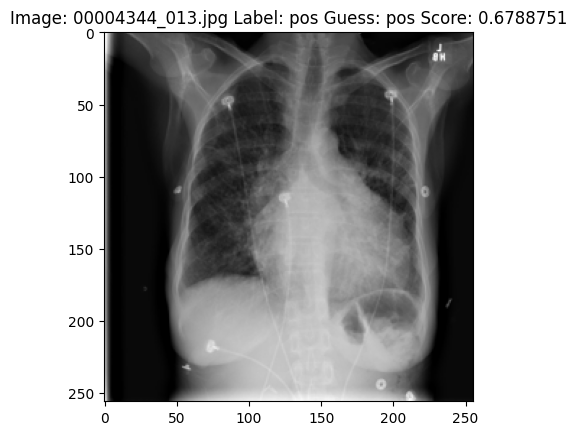

In [36]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

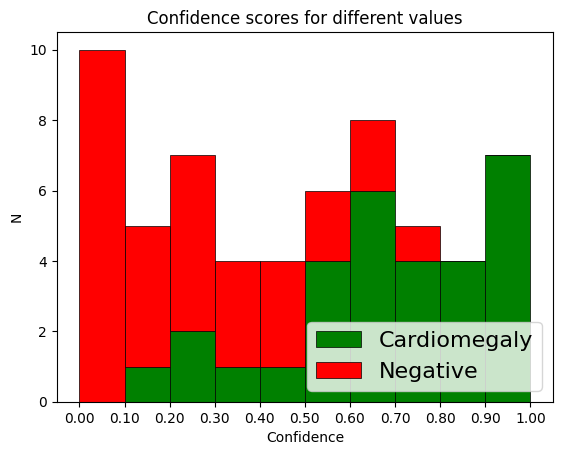

In [33]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

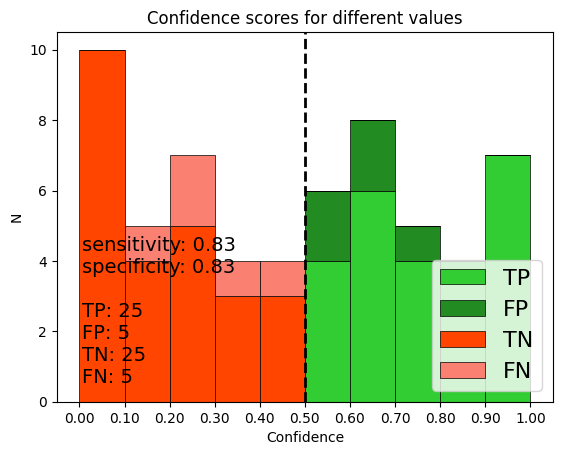

In [37]:
def create_with_cutoff(cutoff):
  _, ax = plt.subplots()
  TP = df.loc[(df['label']=='pos') & (df['confidence'] > cutoff)]['confidence']
  FP = df.loc[(df['label']=='neg') & (df['confidence'] > cutoff)]['confidence']
  TN = df.loc[(df['label']=='neg') & (df['confidence'] < cutoff)]['confidence']
  FN = df.loc[(df['label']=='pos') & (df['confidence'] < cutoff)]['confidence']
  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
           edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
           stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
           label=['TP','FP','TN','FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="lower right", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff=0.5)

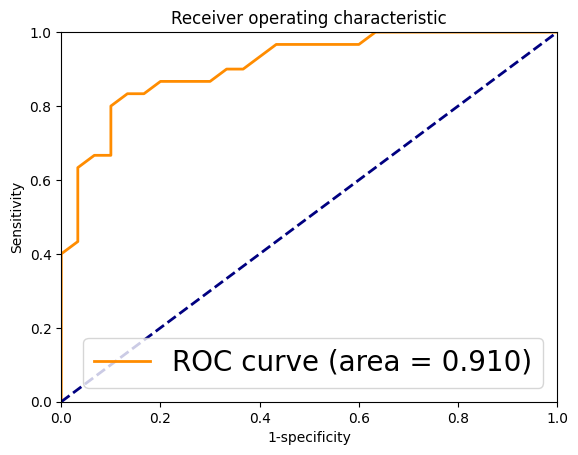

In [38]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

### 5 Save model

In [39]:
os.mkdir('artifacts')

In [40]:
model.save('artifacts/model.h5')

In [41]:
from tensorflow.keras.models import load_model
model = load_model('artifacts/model.h5')